# 不動産価格予測コンペ(Nishika)

- [コンペURL](https://www.nishika.com/competitions/20/summary)

## 目的

- 国内の中古マンションの価格推定

### 設定

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


必要なライブラリーのインストール

In [2]:
!pip install optuna xfeat japanize-matplotlib >> /dev/null

In [3]:
# パスの設定
My_PATH = "/content/drive/MyDrive/property_values_prediction"
%cd {My_PATH}

/content/drive/MyDrive/property_values_prediction


zipファイルの解凍

In [4]:
# data.zipファイルの解凍
# 古いdataのディレクトリ削除
!rm -rf /content/drive/MyDrive/property_values_prediction/data/　　>> /dev/null

import zipfile
with zipfile.ZipFile('data.zip', 'r')as f:
    f.extractall('./data')

# train.zipの解凍
# 古いtrainディレクトリの削除
!rm -rf /content/drive/MyDrive/property_values_prediction/data/train/ >> /dev/null

with zipfile.ZipFile('data/train.zip', 'r')as f:
    f.extractall('./data/')

outputディレクトリの作成

In [5]:
import datetime
import os

now = datetime.datetime.now()
current_time = now.strftime("%Y-%m-%d-%H-%M")
dir_for_output = "./output/" + current_time

os.makedirs(dir_for_output, exist_ok=True)

In [6]:
import re

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.samplers import TPESampler
import pandas as pd
import seaborn as sns
sns.set(font="IPAexGothic")

from glob import glob
from functools import partial
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from xfeat import (
    SelectCategorical,
    LabelEncoder,
    LambdaEncoder,
    Pipeline,
    ConcatCombination,
    SelectNumerical,
    ArithmeticCombinations,
    TargetEncoder,
    aggregation,
    GBDTFeatureSelector,
    GBDTFeatureExplorer,
)

各種関数の設定

In [7]:
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(moyori)
    return moyori

def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area

def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

コンペデータ作成（利用カラム、目的変数など決める）

In [8]:
BASE_PATH = './data/'
RANDOM_STATE = 10

In [9]:
paths = glob(BASE_PATH + 'train/*')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv(BASE_PATH + 'test.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.



In [10]:
train_df.head()

,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log
0,1047763,中古マンション等,NaN,1107,北海道,札幌市西区,西野１条,発寒南,10,３ＬＤＫ,65,NaN,NaN,NaN,昭和53年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種住居地域,60.0,200.0,2020年第２四半期,改装済,NaN,6.991226
1,1003151,中古マンション等,NaN,1101,北海道,札幌市中央区,北１１条西,桑園,5,４ＬＤＫ,80,NaN,NaN,NaN,平成7年,ＲＣ,住宅,住宅,NaN,NaN,NaN,第２種住居地域,60.0,200.0,2018年第２四半期,未改装,NaN,7.278754
2,1004084,中古マンション等,NaN,1101,北海道,札幌市中央区,南１条西,円山公園,6,１Ｒ,20,NaN,NaN,NaN,昭和51年,ＳＲＣ,住宅,NaN,NaN,NaN,NaN,近隣商業地域,80.0,300.0,2012年第１四半期,未改装,NaN,6.361728
3,1056515,中古マンション等,NaN,1107,北海道,札幌市西区,八軒５条西,発寒中央,12,３ＬＤＫ,70,NaN,NaN,NaN,平成6年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第２種中高層住居専用地域,60.0,200.0,2014年第１四半期,改装済,NaN,7.079181
4,1001193,中古マンション等,NaN,1101,北海道,札幌市中央区,北２条西,西１８丁目,6,３ＬＤＫ,75,NaN,NaN,NaN,平成23年,ＲＣ,NaN,住宅,NaN,NaN,NaN,近隣商業地域,80.0,300.0,2019年第３四半期,未改装,NaN,7.505150


In [11]:
# 欠損値の確認
train_df.isnull().sum()

ID                   0
種類                   0
地域              677392
市区町村コード              0
都道府県名                0
市区町村名                0
地区名                660
最寄駅：名称            2672
最寄駅：距離（分）        23098
間取り              23661
面積（㎡）                0
土地の形状           677392
間口              677392
延床面積（㎡）         677392
建築年              19622
建物の構造            16486
用途               58246
今後の利用目的         364049
前面道路：方位         677392
前面道路：種類         677392
前面道路：幅員（ｍ）      677392
都市計画             19221
建ぺい率（％）          23345
容積率（％）           23345
取引時点                 0
改装               61966
取引の事情等          658854
取引価格（総額）_log         0
dtype: int64

In [12]:
# 提出フォーマットの読み込み
sub_df = pd.read_csv(BASE_PATH + 'sample_submission.csv')

In [13]:
ID = 'ID'
TARGET = '取引価格（総額）_log'

In [14]:
df = pd.concat([train_df, test_df])

In [15]:
# 解析対象外のカラムを指定
rm_cols = []
rm_cols += ['市区町村コード']

# ユニーク数が1以下のカラムを解析対象外のカラムとして指定
for i,v in df.nunique().iteritems():
    if v <= 1:
        rm_cols.append(i)

rm_cols

['市区町村コード',
 '種類',
 '地域',
 '土地の形状',
 '間口',
 '延床面積（㎡）',
 '前面道路：方位',
 '前面道路：種類',
 '前面道路：幅員（ｍ）']

In [16]:
# テストデータの目的変数が無いため、np.nan で埋める
test_df[TARGET] = np.nan

# 解析対象外のカラムを削除する
train_df.drop(rm_cols, axis=1, inplace=True)
test_df.drop(rm_cols, axis=1, inplace=True)

# 解析対象に使用するDataFrameを作成
df = pd.concat([train_df, test_df])

# 取引時点(売買契約/四半期単位)でソートし、indexを振り直す
df.sort_values('取引時点', inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(700543, 19)

In [17]:
# 取引時点(売買契約/四半期単位)のユニークを確認
df['取引時点'].unique()

array(['2005年第３四半期', '2005年第４四半期', '2006年第１四半期', '2006年第２四半期',
       '2006年第３四半期', '2006年第４四半期', '2007年第１四半期', '2007年第２四半期',
       '2007年第３四半期', '2007年第４四半期', '2008年第１四半期', '2008年第２四半期',
       '2008年第３四半期', '2008年第４四半期', '2009年第１四半期', '2009年第２四半期',
       '2009年第３四半期', '2009年第４四半期', '2010年第１四半期', '2010年第２四半期',
       '2010年第３四半期', '2010年第４四半期', '2011年第１四半期', '2011年第２四半期',
       '2011年第３四半期', '2011年第４四半期', '2012年第１四半期', '2012年第２四半期',
       '2012年第３四半期', '2012年第４四半期', '2013年第１四半期', '2013年第２四半期',
       '2013年第３四半期', '2013年第４四半期', '2014年第１四半期', '2014年第２四半期',
       '2014年第３四半期', '2014年第４四半期', '2015年第１四半期', '2015年第２四半期',
       '2015年第３四半期', '2015年第４四半期', '2016年第１四半期', '2016年第２四半期',
       '2016年第３四半期', '2016年第４四半期', '2017年第１四半期', '2017年第２四半期',
       '2017年第３四半期', '2017年第４四半期', '2018年第１四半期', '2018年第２四半期',
       '2018年第３四半期', '2018年第４四半期', '2019年第１四半期', '2019年第２四半期',
       '2019年第３四半期', '2019年第４四半期', '2020年第１四半期', '2020年第２四半期',
       '2020年第３四半期', '2020年第４四半期', '2021年第１四半期'], dtype

In [18]:
# valid, testデータのインデックスを指定
val_min_idx = min(df[df['取引時点'].str.contains('2020年第２四半期|2020年第３四半期', regex=True)].index)
test_min_idx = min(df[df['取引時点'].str.contains('2020年第４四半期|2021年第１四半期', regex=True)].index)
val_min_idx, test_min_idx

(652493, 677392)

In [19]:
set(df.iloc[val_min_idx:test_min_idx, :]['取引時点'].values)

{'2020年第２四半期', '2020年第３四半期'}

特徴量生成

In [20]:
# 取引時点(売買契約/四半期単位)を順序尺度に変換
enc_dic = {}
for i, e in enumerate(sorted(list(set(df['取引時点'].values)))):
    enc_dic[e] = i
df['取引時点_enc'] = df['取引時点'].map(enc_dic)
df.tail()

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,取引時点_enc
700538,23000726,愛知県,名古屋市千種区,向陽,池下,6,１ＬＤＫ,60,昭和49年,ＲＣ,住宅,NaN,第１種中高層住居専用地域,60.0,200.0,2021年第１四半期,改装済,NaN,NaN,62
700539,23000787,愛知県,名古屋市千種区,桜が丘,星ケ丘(愛知),11,３ＬＤＫ,80,平成27年,ＲＣ,住宅,住宅,第１種住居地域,60.0,200.0,2021年第１四半期,未改装,NaN,NaN,62
700540,13014303,東京都,新宿区,中落合,落合南長崎,8,１Ｋ,20,平成15年,ＲＣ,NaN,住宅,近隣商業地域,80.0,400.0,2021年第１四半期,未改装,NaN,NaN,62
700541,23001017,愛知県,名古屋市千種区,振甫町,覚王山,15,３ＬＤＫ,70,平成26年,ＲＣ,住宅,住宅,第２種中高層住居専用地域,60.0,200.0,2021年第１四半期,未改装,NaN,NaN,62
700542,12003545,千葉県,千葉市花見川区,幕張町,幕張,16,３ＬＤＫ,80,昭和57年,ＳＲＣ,住宅,住宅,市街化調整区域,60.0,200.0,2021年第１四半期,NaN,NaN,NaN,62


In [21]:
# 都道府県別の取引時点(売買契約/四半期単位)別の平均売買件数を算出
te_dic = {}
time_col = '取引時点_enc'
group_col = '都道府県名'

for i in set(df[time_col].values):
    tmp_df = df[df[time_col] < i]
    te_dic[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()

te_dic[50]

{'三重県': 7.099989772836443,
 '京都府': 7.15593584855535,
 '佐賀県': 7.009937258263499,
 '兵庫県': 7.157742870483325,
 '北海道': 6.965967793677889,
 '千葉県': 7.155825324965048,
 '和歌山県': 7.0226902108157585,
 '埼玉県': 7.169744271396765,
 '大分県': 6.911537826573121,
 '大阪府': 7.158352973821433,
 '奈良県': 7.0568846102346985,
 '宮城県': 7.03954425380504,
 '宮崎県': 6.958678653711221,
 '富山県': 7.046920071386999,
 '山口県': 7.045342730349815,
 '山形県': 7.087990602814885,
 '山梨県': 6.848839888686703,
 '岐阜県': 7.078095913486438,
 '岡山県': 7.038090734927505,
 '岩手県': 6.92500267906058,
 '島根県': 7.16537621470031,
 '広島県': 7.09344902165506,
 '徳島県': 6.912051981629739,
 '愛媛県': 6.9664330115966635,
 '愛知県': 7.107301969238665,
 '新潟県': 6.913835156235099,
 '東京都': 7.377929204637786,
 '栃木県': 6.950636958071022,
 '沖縄県': 7.160046604428345,
 '滋賀県': 7.166026958168428,
 '熊本県': 6.970182251843288,
 '石川県': 6.929363348877184,
 '神奈川県': 7.258118267209654,
 '福井県': 6.979575815840192,
 '福岡県': 6.9922649050422665,
 '福島県': 6.974380579140183,
 '秋田県': 6.94131374711262,
 

In [22]:
# 都道府県別の取引時点(売買契約/四半期単位)別平均売買件数を追加
def calc_te(row):
    if row[time_col] in te_dic and row[group_col] in te_dic[row[time_col]]:
        return te_dic[row[time_col]][row[group_col]]
    else:
        return 0

df[group_col+'_te'] = df.apply(calc_te, axis=1)
df.tail()

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,取引時点_enc,都道府県名_te
700538,23000726,愛知県,名古屋市千種区,向陽,池下,6,１ＬＤＫ,60,昭和49年,ＲＣ,住宅,NaN,第１種中高層住居専用地域,60.0,200.0,2021年第１四半期,改装済,NaN,NaN,62,7.124361
700539,23000787,愛知県,名古屋市千種区,桜が丘,星ケ丘(愛知),11,３ＬＤＫ,80,平成27年,ＲＣ,住宅,住宅,第１種住居地域,60.0,200.0,2021年第１四半期,未改装,NaN,NaN,62,7.124361
700540,13014303,東京都,新宿区,中落合,落合南長崎,8,１Ｋ,20,平成15年,ＲＣ,NaN,住宅,近隣商業地域,80.0,400.0,2021年第１四半期,未改装,NaN,NaN,62,7.396885
700541,23001017,愛知県,名古屋市千種区,振甫町,覚王山,15,３ＬＤＫ,70,平成26年,ＲＣ,住宅,住宅,第２種中高層住居専用地域,60.0,200.0,2021年第１四半期,未改装,NaN,NaN,62,7.124361
700542,12003545,千葉県,千葉市花見川区,幕張町,幕張,16,３ＬＤＫ,80,昭和57年,ＳＲＣ,住宅,住宅,市街化調整区域,60.0,200.0,2021年第１四半期,NaN,NaN,NaN,62,7.161930


In [23]:
df['取引時点_何年前'] = df['取引時点'].apply(lambda x: 2021-int(x[:4]))
df.drop(['取引時点'], axis=1, inplace=True)
df['建築年'] = df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
df['面積（㎡）'] = df['面積（㎡）'].apply(lambda x: normalize_area(x))
df['最寄駅：距離（分）'] = df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))
df.head()

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,改装,取引の事情等,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前
0,27232131,大阪府,大阪市旭区,新森,森小路,6.0,１ＬＤＫ,50,1974.0,ＲＣ,住宅,NaN,準工業地域,80.0,200.0,改装済,NaN,7.041393,0,0.0,16
1,14289301,神奈川県,川崎市高津区,千年新町,武蔵新城,7.0,３ＬＤＫ,60,1992.0,ＲＣ,住宅,NaN,第１種中高層住居専用地域,60.0,200.0,改装済,NaN,7.361728,0,0.0,16
2,13417040,東京都,葛飾区,宝町,お花茶屋,NaN,２ＬＤＫ,60,1993.0,ＲＣ,住宅,NaN,準工業地域,60.0,200.0,改装済,NaN,7.255273,0,0.0,16
3,14267697,神奈川県,横浜市青葉区,あざみ野,あざみ野,NaN,３ＬＤＫ,85,1982.0,NaN,住宅,NaN,NaN,NaN,NaN,NaN,NaN,7.556303,0,0.0,16
4,13386603,東京都,練馬区,豊玉北,練馬,5.0,１Ｋ,20,2005.0,ＲＣ,住宅,NaN,商業地域,80.0,500.0,未改装,NaN,7.278754,0,0.0,16


In [24]:
# 数値データのみを抽出(xfeat)
num_df = SelectNumerical().fit_transform(df)
num_df.head(2)

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前
0,27232131,6.0,50,1974.0,80.0,200.0,7.041393,0,0.0,16
1,14289301,7.0,60,1992.0,60.0,200.0,7.361728,0,0.0,16


In [25]:
# カテゴリデータのラベルエンコーディング
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])

le_df = encoder.fit_transform(df)
le_df.head(2)

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,改装,取引の事情等
0,0,0,0,0,0,0,0,-1,0,0,-1
1,1,1,1,1,1,0,0,-1,1,0,-1


In [26]:
# 面積×容積率を計算
encoder = Pipeline(
    [
        SelectNumerical(),
        ArithmeticCombinations(
            input_cols=["面積（㎡）", "容積率（％）"], 
            drop_origin=True, 
            operator="*", 
            r=2,
        ),
    ]
)

num_comb_df = encoder.fit_transform(df)/100
num_comb_df.head(2)

,面積（㎡）容積率（％）_combi
0,100.0
1,120.0


In [27]:
encoder = Pipeline([
                    SelectCategorical(exclude_cols=[]),
                    ConcatCombination(drop_origin=True, output_suffix="", r=2),
                    LabelEncoder(output_suffix=""),
                    ])

cal_comb_df = encoder.fit_transform(df)
cal_comb_df.head(2)

,都道府県名市区町村名,都道府県名地区名,都道府県名最寄駅：名称,都道府県名間取り,都道府県名建物の構造,都道府県名用途,都道府県名今後の利用目的,都道府県名都市計画,都道府県名改装,都道府県名取引の事情等,市区町村名地区名,市区町村名最寄駅：名称,市区町村名間取り,市区町村名建物の構造,市区町村名用途,市区町村名今後の利用目的,市区町村名都市計画,市区町村名改装,市区町村名取引の事情等,地区名最寄駅：名称,地区名間取り,地区名建物の構造,地区名用途,地区名今後の利用目的,地区名都市計画,地区名改装,地区名取引の事情等,最寄駅：名称間取り,最寄駅：名称建物の構造,最寄駅：名称用途,最寄駅：名称今後の利用目的,最寄駅：名称都市計画,最寄駅：名称改装,最寄駅：名称取引の事情等,間取り建物の構造,間取り用途,間取り今後の利用目的,間取り都市計画,間取り改装,間取り取引の事情等,建物の構造用途,建物の構造今後の利用目的,建物の構造都市計画,建物の構造改装,建物の構造取引の事情等,用途今後の利用目的,用途都市計画,用途改装,用途取引の事情等,今後の利用目的都市計画,今後の利用目的改装,今後の利用目的取引の事情等,都市計画改装,都市計画取引の事情等,改装取引の事情等
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0


In [28]:
agg_dfs = []

def get_agg_df(df, group_col):

    agg_df, agg_cols = aggregation(
        df,
        group_key=group_col,
        group_values=['最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）'],
        agg_methods=['count', 'mean', 'min', 'max', 'median', 'std'],
        )

    return agg_df[agg_cols]

group_col = '市区町村名'
agg_dfs.append(get_agg_df(df, group_col))
agg_dfs[0].head(2)

,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_面積（㎡）_grpby_市区町村名,agg_count_建ぺい率（％）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_面積（㎡）_grpby_市区町村名,agg_mean_建ぺい率（％）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_面積（㎡）_grpby_市区町村名,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名,agg_median_最寄駅：距離（分）_grpby_市区町村名,agg_median_面積（㎡）_grpby_市区町村名,agg_median_建ぺい率（％）_grpby_市区町村名,agg_median_容積率（％）_grpby_市区町村名,agg_std_最寄駅：距離（分）_grpby_市区町村名,agg_std_面積（㎡）_grpby_市区町村名,agg_std_建ぺい率（％）_grpby_市区町村名,agg_std_容積率（％）_grpby_市区町村名
0,789,808,806,806,8.206591,59.814356,70.397022,236.228288,0.0,15,60.0,200.0,23.0,115,80.0,400.0,8.0,60.0,80.0,200.0,4.327536,16.170642,9.998320,61.473966
1,2945,3089,2872,2872,13.020713,59.043380,61.922006,212.580084,0.0,15,40.0,80.0,105.0,550,80.0,1100.0,10.0,65.0,60.0,200.0,10.878025,23.045336,6.448643,56.522903


In [29]:
feat_df = pd.concat([num_df,le_df,num_comb_df,cal_comb_df]+agg_dfs, axis=1)
print(feat_df.shape)

(700543, 101)


In [30]:
feat_df.dtypes

ID                                 int64
最寄駅：距離（分）                        float64
面積（㎡）                              int64
建築年                              float64
建ぺい率（％）                          float64
                                  ...   
agg_median_容積率（％）_grpby_市区町村名    float64
agg_std_最寄駅：距離（分）_grpby_市区町村名    float64
agg_std_面積（㎡）_grpby_市区町村名        float64
agg_std_建ぺい率（％）_grpby_市区町村名      float64
agg_std_容積率（％）_grpby_市区町村名       float64
Length: 101, dtype: object

モデル構築

In [31]:
train_df = feat_df.iloc[:val_min_idx, :]
val_df = feat_df.iloc[val_min_idx:test_min_idx, :]
test_df = feat_df.iloc[test_min_idx:, :]
print(train_df.shape, val_df.shape, test_df.shape)

(652493, 101) (24899, 101) (23151, 101)


In [32]:
feat_cols = [col for col in train_df.columns if col not in rm_cols+[ID, TARGET]]

In [33]:
cat_cols = list(le_df.columns) + ['取引時点_enc']
cat_cols

['都道府県名',
 '市区町村名',
 '地区名',
 '最寄駅：名称',
 '間取り',
 '建物の構造',
 '用途',
 '今後の利用目的',
 '都市計画',
 '改装',
 '取引の事情等',
 '取引時点_enc']

In [34]:
train_x = train_df[feat_cols]
train_y = train_df[TARGET]
val_x = val_df[feat_cols]
val_y = val_df[TARGET]
test_x = test_df[feat_cols]
test_y = test_df[TARGET]

In [35]:
def objective(trial):

    params = {
        "objective": "mean_squared_error",
        "metric": "mae",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    # LightGBMを利用するのに必要なフォーマットに変換
    lgb_train = lgb.Dataset(train_x, train_y)
    lgb_eval = lgb.Dataset(val_x, val_y, reference=lgb_train)

    # 学習の経過を保存する箱
    evaluation_results = {}

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=1000,
        valid_names=["train", "valid"],
        valid_sets=[lgb_train, lgb_eval],
        evals_result=evaluation_results,
        early_stopping_rounds=50,
        verbose_eval=250,
    )

    preds = model.predict(val_x)
    mae = mean_absolute_error(val_y, preds)

    return mae

In [37]:
%%time
# optunaで最適値を見つける
# create_studyメソッドの引数"sampler"にサンプラーと乱数シードを指定
study = optuna.create_study(
    direction="minimize", sampler=TPESampler(seed=RANDOM_STATE)
)
study.optimize(objective, n_trials=50)

[I 2021-11-30 03:11:25,571] A new study created in memory with name: no-name-7374c347-72c2-46fa-9d9b-ae679b873a3a


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0756018	valid's l1: 0.0824978
[500]	train's l1: 0.069793	valid's l1: 0.0801905
[750]	train's l1: 0.0658487	valid's l1: 0.079583
[1000]	train's l1: 0.0626641	valid's l1: 0.0791799
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0626641	valid's l1: 0.0791799


[I 2021-11-30 03:15:58,699] Trial 0 finished with value: 0.07917990285034715 and parameters: {'lambda_l1': 0.08747537025773001, 'lambda_l2': 1.537331564587801e-08, 'num_leaves': 163, 'feature_fraction': 0.8492823295231671, 'bagging_fraction': 0.6991042073815543, 'bagging_freq': 2, 'min_child_samples': 24}. Best is trial 0 with value: 0.07917990285034715.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0882913	valid's l1: 0.0909412
[500]	train's l1: 0.0837543	valid's l1: 0.0868402
[750]	train's l1: 0.0811767	valid's l1: 0.0848048
[1000]	train's l1: 0.0792444	valid's l1: 0.0833103
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0792444	valid's l1: 0.0833103


[I 2021-11-30 03:18:54,680] Trial 1 finished with value: 0.0833103119087523 and parameters: {'lambda_l1': 0.0699481785242808, 'lambda_l2': 3.32657660618516e-07, 'num_leaves': 24, 'feature_fraction': 0.8112158910206784, 'bagging_fraction': 0.972036007716962, 'bagging_freq': 1, 'min_child_samples': 54}. Best is trial 0 with value: 0.07917990285034715.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0745441	valid's l1: 0.081115
[500]	train's l1: 0.0690006	valid's l1: 0.0791376
[750]	train's l1: 0.0650981	valid's l1: 0.0781986
[1000]	train's l1: 0.0619665	valid's l1: 0.0778012
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0619665	valid's l1: 0.0778012


[I 2021-11-30 03:23:01,393] Trial 2 finished with value: 0.07780124658960738 and parameters: {'lambda_l1': 0.20586790968905005, 'lambda_l2': 0.003256376421394008, 'num_leaves': 186, 'feature_fraction': 0.5751256409023799, 'bagging_fraction': 0.9506644735077661, 'bagging_freq': 6, 'min_child_samples': 57}. Best is trial 2 with value: 0.07780124658960738.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0752839	valid's l1: 0.0823876
[500]	train's l1: 0.0698175	valid's l1: 0.0803308
[750]	train's l1: 0.0659577	valid's l1: 0.0796175
[1000]	train's l1: 0.0629514	valid's l1: 0.0793209
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0629514	valid's l1: 0.0793209


[I 2021-11-30 03:27:00,908] Trial 3 finished with value: 0.07932094227709036 and parameters: {'lambda_l1': 1.9034015928564192e-07, 'lambda_l2': 2.2912202578440842e-05, 'num_leaves': 173, 'feature_fraction': 0.6650999046537976, 'bagging_fraction': 0.6604083959999762, 'bagging_freq': 5, 'min_child_samples': 54}. Best is trial 2 with value: 0.07780124658960738.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0735938	valid's l1: 0.0817548
[500]	train's l1: 0.0672876	valid's l1: 0.0795928
[750]	train's l1: 0.0628842	valid's l1: 0.0790482
[1000]	train's l1: 0.0592921	valid's l1: 0.0787857
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0592921	valid's l1: 0.0787857


[I 2021-11-30 03:31:57,532] Trial 4 finished with value: 0.07878566867581441 and parameters: {'lambda_l1': 0.007137968669448066, 'lambda_l2': 0.0025665550309028774, 'num_leaves': 207, 'feature_fraction': 0.7129882914361805, 'bagging_fraction': 0.945189328485201, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 2 with value: 0.07780124658960738.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0741662	valid's l1: 0.0815893
[500]	train's l1: 0.068434	valid's l1: 0.0795262
[750]	train's l1: 0.0645841	valid's l1: 0.0788241
[1000]	train's l1: 0.0615383	valid's l1: 0.0784013
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0615383	valid's l1: 0.0784013


[I 2021-11-30 03:35:33,881] Trial 5 finished with value: 0.07840134040109915 and parameters: {'lambda_l1': 5.085111847677709e-06, 'lambda_l2': 1.0613515458050516e-07, 'num_leaves': 213, 'feature_fraction': 0.42813779163354987, 'bagging_fraction': 0.7757722889868355, 'bagging_freq': 4, 'min_child_samples': 83}. Best is trial 2 with value: 0.07780124658960738.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0802395	valid's l1: 0.0849318
[500]	train's l1: 0.0754335	valid's l1: 0.0824153
[750]	train's l1: 0.0721854	valid's l1: 0.0811024
[1000]	train's l1: 0.0697134	valid's l1: 0.0805446
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0697134	valid's l1: 0.0805446


[I 2021-11-30 03:38:40,392] Trial 6 finished with value: 0.08054465080796831 and parameters: {'lambda_l1': 6.173448891970491e-07, 'lambda_l2': 0.5148168134404182, 'num_leaves': 91, 'feature_fraction': 0.8527886149179144, 'bagging_fraction': 0.5775770241278072, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 2 with value: 0.07780124658960738.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0882366	valid's l1: 0.0906789
[500]	train's l1: 0.0839876	valid's l1: 0.0870389
[750]	train's l1: 0.081666	valid's l1: 0.0852783
[1000]	train's l1: 0.079954	valid's l1: 0.0841371
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.079954	valid's l1: 0.0841371


[I 2021-11-30 03:40:48,472] Trial 7 finished with value: 0.08413713487124236 and parameters: {'lambda_l1': 3.055927730910031e-07, 'lambda_l2': 3.4100692264414245e-05, 'num_leaves': 25, 'feature_fraction': 0.892663394702157, 'bagging_fraction': 0.4906912117855383, 'bagging_freq': 3, 'min_child_samples': 95}. Best is trial 2 with value: 0.07780124658960738.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0760696	valid's l1: 0.081682
[500]	train's l1: 0.0717664	valid's l1: 0.0795213
[750]	train's l1: 0.069208	valid's l1: 0.0786679
[1000]	train's l1: 0.0672848	valid's l1: 0.0782602
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0672848	valid's l1: 0.0782602


[I 2021-11-30 03:46:07,361] Trial 8 finished with value: 0.07826016545149224 and parameters: {'lambda_l1': 7.738009776978926, 'lambda_l2': 0.00012786183233975197, 'num_leaves': 212, 'feature_fraction': 0.5508244805242356, 'bagging_fraction': 0.7584229889385306, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 2 with value: 0.07780124658960738.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.080076	valid's l1: 0.0842765
[500]	train's l1: 0.0754595	valid's l1: 0.0816697
[750]	train's l1: 0.0724968	valid's l1: 0.0805342
[1000]	train's l1: 0.070189	valid's l1: 0.079782
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.070189	valid's l1: 0.079782


[I 2021-11-30 03:48:29,468] Trial 9 finished with value: 0.07978200542871838 and parameters: {'lambda_l1': 0.0020502757114657026, 'lambda_l2': 2.2570225857344917e-08, 'num_leaves': 93, 'feature_fraction': 0.44776785409357855, 'bagging_fraction': 0.583275951005691, 'bagging_freq': 3, 'min_child_samples': 79}. Best is trial 2 with value: 0.07780124658960738.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0731782	valid's l1: 0.0805574
[500]	train's l1: 0.0681114	valid's l1: 0.0787388
[750]	train's l1: 0.0647724	valid's l1: 0.0781707
[1000]	train's l1: 0.0622037	valid's l1: 0.0778384
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0622037	valid's l1: 0.0778384


[I 2021-11-30 03:54:02,198] Trial 10 finished with value: 0.07783841038450118 and parameters: {'lambda_l1': 2.868552689905226, 'lambda_l2': 6.220571289776148, 'num_leaves': 251, 'feature_fraction': 0.5856758760408701, 'bagging_fraction': 0.8718151830203783, 'bagging_freq': 6, 'min_child_samples': 70}. Best is trial 2 with value: 0.07780124658960738.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0733372	valid's l1: 0.0808125
[500]	train's l1: 0.0681959	valid's l1: 0.0789867
[750]	train's l1: 0.0648625	valid's l1: 0.0783246
[1000]	train's l1: 0.0623028	valid's l1: 0.0779882
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0623028	valid's l1: 0.0779882


[I 2021-11-30 03:59:25,334] Trial 11 finished with value: 0.07798823521760286 and parameters: {'lambda_l1': 2.8231671799515703, 'lambda_l2': 7.114706206078692, 'num_leaves': 251, 'feature_fraction': 0.5685849429567916, 'bagging_fraction': 0.8300284786165766, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 2 with value: 0.07780124658960738.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0720688	valid's l1: 0.0803738
[500]	train's l1: 0.0657931	valid's l1: 0.0783828
[750]	train's l1: 0.0614496	valid's l1: 0.0778189
[1000]	train's l1: 0.0580292	valid's l1: 0.0775909
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0580292	valid's l1: 0.0775909


[I 2021-11-30 04:04:04,861] Trial 12 finished with value: 0.07759088558063454 and parameters: {'lambda_l1': 9.017311082386353e-05, 'lambda_l2': 0.023760912648964096, 'num_leaves': 256, 'feature_fraction': 0.5806589490719759, 'bagging_fraction': 0.888943109883453, 'bagging_freq': 5, 'min_child_samples': 68}. Best is trial 12 with value: 0.07759088558063454.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0764272	valid's l1: 0.0826829
[500]	train's l1: 0.0709192	valid's l1: 0.0801607
[750]	train's l1: 0.06723	valid's l1: 0.079132
[1000]	train's l1: 0.0642796	valid's l1: 0.0786426
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0642796	valid's l1: 0.0786426


[I 2021-11-30 04:08:18,738] Trial 13 finished with value: 0.07864258133382834 and parameters: {'lambda_l1': 4.572924549666539e-05, 'lambda_l2': 0.013194573517980942, 'num_leaves': 142, 'feature_fraction': 0.6843233375793412, 'bagging_fraction': 0.9979000611889807, 'bagging_freq': 5, 'min_child_samples': 39}. Best is trial 12 with value: 0.07759088558063454.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0738547	valid's l1: 0.0813393
[500]	train's l1: 0.0680163	valid's l1: 0.079403
[750]	train's l1: 0.0639362	valid's l1: 0.0787599
[1000]	train's l1: 0.0606924	valid's l1: 0.0784906
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0606924	valid's l1: 0.0784906


[I 2021-11-30 04:14:26,913] Trial 14 finished with value: 0.07849062709940569 and parameters: {'lambda_l1': 0.00014991513066377969, 'lambda_l2': 0.021830332919154514, 'num_leaves': 190, 'feature_fraction': 0.9949145705632823, 'bagging_fraction': 0.8868148959054026, 'bagging_freq': 5, 'min_child_samples': 65}. Best is trial 12 with value: 0.07759088558063454.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0725019	valid's l1: 0.0807655
[500]	train's l1: 0.0663961	valid's l1: 0.078839
[750]	train's l1: 0.0622206	valid's l1: 0.0781349
[1000]	train's l1: 0.0589415	valid's l1: 0.0779614
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0589415	valid's l1: 0.0779614


[I 2021-11-30 04:18:54,565] Trial 15 finished with value: 0.07796145236494184 and parameters: {'lambda_l1': 1.765568596075514e-05, 'lambda_l2': 0.001028418345413027, 'num_leaves': 255, 'feature_fraction': 0.49563682804094145, 'bagging_fraction': 0.8905995428488237, 'bagging_freq': 6, 'min_child_samples': 99}. Best is trial 12 with value: 0.07759088558063454.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0785235	valid's l1: 0.0837081
[500]	train's l1: 0.0734212	valid's l1: 0.0811428
[750]	train's l1: 0.0700162	valid's l1: 0.0801216
[1000]	train's l1: 0.0672428	valid's l1: 0.0794031
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0672428	valid's l1: 0.0794031


[I 2021-11-30 04:22:17,215] Trial 16 finished with value: 0.07940308023368557 and parameters: {'lambda_l1': 0.0014794205845129955, 'lambda_l2': 0.1808710872978695, 'num_leaves': 111, 'feature_fraction': 0.6240142390959726, 'bagging_fraction': 0.7893796446442393, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 12 with value: 0.07759088558063454.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0726843	valid's l1: 0.080941
[500]	train's l1: 0.0665974	valid's l1: 0.0790548
[750]	train's l1: 0.0623618	valid's l1: 0.0783043
[1000]	train's l1: 0.0589919	valid's l1: 0.0781055
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0589919	valid's l1: 0.0781055


[I 2021-11-30 04:27:35,155] Trial 17 finished with value: 0.07810548452785684 and parameters: {'lambda_l1': 0.11678515795319928, 'lambda_l2': 1.6552006191858444e-06, 'num_leaves': 228, 'feature_fraction': 0.7281728243847296, 'bagging_fraction': 0.9126004205502819, 'bagging_freq': 6, 'min_child_samples': 65}. Best is trial 12 with value: 0.07759088558063454.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0768153	valid's l1: 0.0825352
[500]	train's l1: 0.0716642	valid's l1: 0.0802794
[750]	train's l1: 0.068217	valid's l1: 0.0794071
[1000]	train's l1: 0.065494	valid's l1: 0.0788856
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.065494	valid's l1: 0.0788856


[I 2021-11-30 04:30:54,959] Trial 18 finished with value: 0.07888558128070317 and parameters: {'lambda_l1': 2.604404331091175e-06, 'lambda_l2': 0.030094996829258175, 'num_leaves': 142, 'feature_fraction': 0.5057369927317192, 'bagging_fraction': 0.8154323579528954, 'bagging_freq': 5, 'min_child_samples': 87}. Best is trial 12 with value: 0.07759088558063454.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.075972	valid's l1: 0.0830528
[500]	train's l1: 0.0706038	valid's l1: 0.0811163
[750]	train's l1: 0.0670638	valid's l1: 0.0804276
Early stopping, best iteration is:
[745]	train's l1: 0.0671152	valid's l1: 0.0803935


[I 2021-11-30 04:34:01,770] Trial 19 finished with value: 0.0803935152564745 and parameters: {'lambda_l1': 2.572369314374166e-08, 'lambda_l2': 0.4988059520816624, 'num_leaves': 174, 'feature_fraction': 0.7717834632474819, 'bagging_fraction': 0.43912713666740794, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 12 with value: 0.07759088558063454.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0835888	valid's l1: 0.0869836
[500]	train's l1: 0.0791298	valid's l1: 0.0836973
[750]	train's l1: 0.0763941	valid's l1: 0.0821232
[1000]	train's l1: 0.074284	valid's l1: 0.0812049
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.074284	valid's l1: 0.0812049


[I 2021-11-30 04:36:28,407] Trial 20 finished with value: 0.08120487077173502 and parameters: {'lambda_l1': 0.0004674157687623061, 'lambda_l2': 0.002069366985701025, 'num_leaves': 51, 'feature_fraction': 0.6270271579551668, 'bagging_fraction': 0.7191846655387528, 'bagging_freq': 4, 'min_child_samples': 27}. Best is trial 12 with value: 0.07759088558063454.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0729351	valid's l1: 0.0808512
[500]	train's l1: 0.0670992	valid's l1: 0.0788312
[750]	train's l1: 0.0631959	valid's l1: 0.078221
[1000]	train's l1: 0.0601271	valid's l1: 0.0779619
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0601271	valid's l1: 0.0779619


[I 2021-11-30 04:40:59,420] Trial 21 finished with value: 0.07796192700048325 and parameters: {'lambda_l1': 0.6817558194089045, 'lambda_l2': 2.4963501348871016, 'num_leaves': 238, 'feature_fraction': 0.5806360899185684, 'bagging_fraction': 0.8477659451342324, 'bagging_freq': 6, 'min_child_samples': 73}. Best is trial 12 with value: 0.07759088558063454.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0730785	valid's l1: 0.0805246
[500]	train's l1: 0.067253	valid's l1: 0.0786358
[750]	train's l1: 0.0632365	valid's l1: 0.0779145
[1000]	train's l1: 0.0600771	valid's l1: 0.077503
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0600771	valid's l1: 0.077503


[I 2021-11-30 04:45:09,723] Trial 22 finished with value: 0.07750296589741844 and parameters: {'lambda_l1': 0.4639911447026122, 'lambda_l2': 0.10044358136173888, 'num_leaves': 229, 'feature_fraction': 0.5230049009653983, 'bagging_fraction': 0.9353392788282284, 'bagging_freq': 6, 'min_child_samples': 65}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0742427	valid's l1: 0.0813555
[500]	train's l1: 0.0685102	valid's l1: 0.0790398
[750]	train's l1: 0.0645255	valid's l1: 0.0781897
[1000]	train's l1: 0.0613856	valid's l1: 0.0778938
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0613856	valid's l1: 0.0778938


[I 2021-11-30 04:49:02,999] Trial 23 finished with value: 0.07789378803711638 and parameters: {'lambda_l1': 0.020967196020650638, 'lambda_l2': 0.0839664727084524, 'num_leaves': 197, 'feature_fraction': 0.5167432110073066, 'bagging_fraction': 0.944263282693503, 'bagging_freq': 5, 'min_child_samples': 61}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0737907	valid's l1: 0.0814473
[500]	train's l1: 0.0678437	valid's l1: 0.0791776
[750]	train's l1: 0.0639794	valid's l1: 0.0784629
[1000]	train's l1: 0.0608367	valid's l1: 0.0780678
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0608367	valid's l1: 0.0780678


[I 2021-11-30 04:52:42,486] Trial 24 finished with value: 0.07806785058284701 and parameters: {'lambda_l1': 0.5699200446385769, 'lambda_l2': 0.0076342821424428935, 'num_leaves': 221, 'feature_fraction': 0.44532588530054606, 'bagging_fraction': 0.926263426103402, 'bagging_freq': 7, 'min_child_samples': 48}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0727228	valid's l1: 0.0805123
[500]	train's l1: 0.0666922	valid's l1: 0.07838
[750]	train's l1: 0.0625334	valid's l1: 0.0777
Early stopping, best iteration is:
[749]	train's l1: 0.0625482	valid's l1: 0.0776955


[I 2021-11-30 04:56:58,633] Trial 25 finished with value: 0.07769555423677169 and parameters: {'lambda_l1': 0.007612717019379641, 'lambda_l2': 0.0006049472207938407, 'num_leaves': 233, 'feature_fraction': 0.6371646732795885, 'bagging_fraction': 0.9640281884010017, 'bagging_freq': 6, 'min_child_samples': 88}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0726577	valid's l1: 0.0806303
[500]	train's l1: 0.0667245	valid's l1: 0.078922
[750]	train's l1: 0.0626077	valid's l1: 0.0781866
Early stopping, best iteration is:
[948]	train's l1: 0.0599598	valid's l1: 0.0779436


[I 2021-11-30 05:02:21,315] Trial 26 finished with value: 0.07794358108281368 and parameters: {'lambda_l1': 0.007606605262771613, 'lambda_l2': 0.0002809043713159028, 'num_leaves': 231, 'feature_fraction': 0.6411043871054081, 'bagging_fraction': 0.9928798299687488, 'bagging_freq': 4, 'min_child_samples': 89}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0730177	valid's l1: 0.080915
[500]	train's l1: 0.0670719	valid's l1: 0.0789819
[750]	train's l1: 0.0628955	valid's l1: 0.0782405
Early stopping, best iteration is:
[797]	train's l1: 0.0622398	valid's l1: 0.0781532


[I 2021-11-30 05:05:54,552] Trial 27 finished with value: 0.07815323592064462 and parameters: {'lambda_l1': 0.0001367675435745963, 'lambda_l2': 5.852215852676031e-06, 'num_leaves': 237, 'feature_fraction': 0.48205196953134977, 'bagging_fraction': 0.8698330751497374, 'bagging_freq': 5, 'min_child_samples': 79}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0727705	valid's l1: 0.0805068
[500]	train's l1: 0.066773	valid's l1: 0.0787686
[750]	train's l1: 0.0626848	valid's l1: 0.0780377
Early stopping, best iteration is:
[814]	train's l1: 0.0617673	valid's l1: 0.0779034


[I 2021-11-30 05:09:15,037] Trial 28 finished with value: 0.07790342520160905 and parameters: {'lambda_l1': 0.0011643257363789534, 'lambda_l2': 0.0005493766304358408, 'num_leaves': 254, 'feature_fraction': 0.40522615528126354, 'bagging_fraction': 0.9105081993508226, 'bagging_freq': 7, 'min_child_samples': 94}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.077015	valid's l1: 0.0825067
[500]	train's l1: 0.0719314	valid's l1: 0.0803688
[750]	train's l1: 0.0685181	valid's l1: 0.0796044
[1000]	train's l1: 0.0658033	valid's l1: 0.0790754
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0658033	valid's l1: 0.0790754


[I 2021-11-30 05:12:25,061] Trial 29 finished with value: 0.07907543660281599 and parameters: {'lambda_l1': 0.05030255224503505, 'lambda_l2': 0.8258846701250979, 'num_leaves': 140, 'feature_fraction': 0.543326747788432, 'bagging_fraction': 0.6683607048051232, 'bagging_freq': 6, 'min_child_samples': 69}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0758412	valid's l1: 0.0821726
[500]	train's l1: 0.0704228	valid's l1: 0.0801242
[750]	train's l1: 0.0667662	valid's l1: 0.0791645
[1000]	train's l1: 0.0638781	valid's l1: 0.0787698
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0638781	valid's l1: 0.0787698


[I 2021-11-30 05:16:51,332] Trial 30 finished with value: 0.0787698462672923 and parameters: {'lambda_l1': 0.025596237207865635, 'lambda_l2': 0.05226931921993836, 'num_leaves': 156, 'feature_fraction': 0.7579858829420016, 'bagging_fraction': 0.740482843892182, 'bagging_freq': 1, 'min_child_samples': 86}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0747373	valid's l1: 0.0815456
[500]	train's l1: 0.0691201	valid's l1: 0.0793101
[750]	train's l1: 0.0653167	valid's l1: 0.0783484
[1000]	train's l1: 0.0623703	valid's l1: 0.0779056
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0623703	valid's l1: 0.0779056


[I 2021-11-30 05:21:14,802] Trial 31 finished with value: 0.07790560661639549 and parameters: {'lambda_l1': 0.43105739613587674, 'lambda_l2': 0.004733186555704004, 'num_leaves': 183, 'feature_fraction': 0.5988719670776528, 'bagging_fraction': 0.9702921649683875, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0736613	valid's l1: 0.081049
[500]	train's l1: 0.0678774	valid's l1: 0.0791167
[750]	train's l1: 0.0637979	valid's l1: 0.0782027
[1000]	train's l1: 0.0605738	valid's l1: 0.0778099
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0605738	valid's l1: 0.0778099


[I 2021-11-30 05:25:55,191] Trial 32 finished with value: 0.07780989139661296 and parameters: {'lambda_l1': 0.25958839429999603, 'lambda_l2': 9.888602675429213e-05, 'num_leaves': 203, 'feature_fraction': 0.6585748914687733, 'bagging_fraction': 0.9622093226355444, 'bagging_freq': 6, 'min_child_samples': 48}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0727793	valid's l1: 0.0807048
[500]	train's l1: 0.0666635	valid's l1: 0.0786097
[750]	train's l1: 0.062384	valid's l1: 0.0780707
Early stopping, best iteration is:
[869]	train's l1: 0.060688	valid's l1: 0.0778605


[I 2021-11-30 05:30:21,156] Trial 33 finished with value: 0.0778604606050618 and parameters: {'lambda_l1': 0.004708666177017775, 'lambda_l2': 0.1200378126987577, 'num_leaves': 233, 'feature_fraction': 0.6063640782564843, 'bagging_fraction': 0.9314753524981714, 'bagging_freq': 5, 'min_child_samples': 57}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0734298	valid's l1: 0.0812051
[500]	train's l1: 0.0675421	valid's l1: 0.0791983
[750]	train's l1: 0.0634428	valid's l1: 0.0785255
[1000]	train's l1: 0.0602643	valid's l1: 0.0782324
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0602643	valid's l1: 0.0782324


[I 2021-11-30 05:34:35,599] Trial 34 finished with value: 0.07823244529048262 and parameters: {'lambda_l1': 0.12359861879536387, 'lambda_l2': 0.0010999571039793238, 'num_leaves': 222, 'feature_fraction': 0.5183669181243935, 'bagging_fraction': 0.842877305352656, 'bagging_freq': 5, 'min_child_samples': 66}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0747916	valid's l1: 0.0813091
[500]	train's l1: 0.0695648	valid's l1: 0.0792143
[750]	train's l1: 0.0661798	valid's l1: 0.0782635
[1000]	train's l1: 0.0635164	valid's l1: 0.0776763
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0635164	valid's l1: 0.0776763


[I 2021-11-30 05:39:33,718] Trial 35 finished with value: 0.0776763523177571 and parameters: {'lambda_l1': 1.6746129913825918, 'lambda_l2': 0.0051176733157259425, 'num_leaves': 184, 'feature_fraction': 0.6822997956957446, 'bagging_fraction': 0.9709250405026685, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0751277	valid's l1: 0.0813379
[500]	train's l1: 0.0708112	valid's l1: 0.0791089
[750]	train's l1: 0.0681139	valid's l1: 0.0782999
[1000]	train's l1: 0.0660848	valid's l1: 0.0778356
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0660848	valid's l1: 0.0778356


[I 2021-11-30 05:45:35,701] Trial 36 finished with value: 0.07783561056250624 and parameters: {'lambda_l1': 6.01788491193608, 'lambda_l2': 0.008929761945821587, 'num_leaves': 200, 'feature_fraction': 0.6765160734745918, 'bagging_fraction': 0.9998962241217351, 'bagging_freq': 7, 'min_child_samples': 79}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0756677	valid's l1: 0.0820569
[500]	train's l1: 0.0704821	valid's l1: 0.0797111
[750]	train's l1: 0.0670333	valid's l1: 0.0786548
[1000]	train's l1: 0.0643767	valid's l1: 0.0781444
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0643767	valid's l1: 0.0781444


[I 2021-11-30 05:50:26,266] Trial 37 finished with value: 0.0781444424236441 and parameters: {'lambda_l1': 1.3688579106112444, 'lambda_l2': 0.2594337654338399, 'num_leaves': 158, 'feature_fraction': 0.717524352081573, 'bagging_fraction': 0.9666603944921969, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0748612	valid's l1: 0.0817745
[500]	train's l1: 0.0693424	valid's l1: 0.0797582
[750]	train's l1: 0.0654965	valid's l1: 0.0789691
[1000]	train's l1: 0.0624604	valid's l1: 0.0786381
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0624604	valid's l1: 0.0786381


[I 2021-11-30 05:55:32,150] Trial 38 finished with value: 0.07863812124165079 and parameters: {'lambda_l1': 0.019498237206034608, 'lambda_l2': 1.6014699590722348, 'num_leaves': 177, 'feature_fraction': 0.8016790016563115, 'bagging_fraction': 0.8044481564593355, 'bagging_freq': 4, 'min_child_samples': 92}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0735926	valid's l1: 0.0810391
[500]	train's l1: 0.067752	valid's l1: 0.0792213
[750]	train's l1: 0.0637648	valid's l1: 0.0785109
[1000]	train's l1: 0.0606151	valid's l1: 0.0782073
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0606151	valid's l1: 0.0782073


[I 2021-11-30 05:59:43,681] Trial 39 finished with value: 0.07820734281663025 and parameters: {'lambda_l1': 2.3680937275657193e-05, 'lambda_l2': 4.4597924416663666e-05, 'num_leaves': 214, 'feature_fraction': 0.552460509346197, 'bagging_fraction': 0.9059647118579631, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0734599	valid's l1: 0.0815668
[500]	train's l1: 0.0676934	valid's l1: 0.0799509
[750]	train's l1: 0.0637069	valid's l1: 0.0793651
Early stopping, best iteration is:
[791]	train's l1: 0.0631267	valid's l1: 0.0792663


[I 2021-11-30 06:02:46,822] Trial 40 finished with value: 0.07926634512612815 and parameters: {'lambda_l1': 0.0004836392005712093, 'lambda_l2': 8.31476739241818e-06, 'num_leaves': 242, 'feature_fraction': 0.47427488973926335, 'bagging_fraction': 0.6025153269441065, 'bagging_freq': 7, 'min_child_samples': 74}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0745094	valid's l1: 0.0808793
[500]	train's l1: 0.0692535	valid's l1: 0.0788509
[750]	train's l1: 0.0657935	valid's l1: 0.0779917
[1000]	train's l1: 0.0630798	valid's l1: 0.0775871
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0630798	valid's l1: 0.0775871


[I 2021-11-30 06:07:40,223] Trial 41 finished with value: 0.077587112895551 and parameters: {'lambda_l1': 1.6051735012463526, 'lambda_l2': 0.002901413117946514, 'num_leaves': 190, 'feature_fraction': 0.6527283156737704, 'bagging_fraction': 0.9495367027847027, 'bagging_freq': 6, 'min_child_samples': 62}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0735428	valid's l1: 0.0808905
[500]	train's l1: 0.068063	valid's l1: 0.0788078
[750]	train's l1: 0.0644551	valid's l1: 0.0780361
[1000]	train's l1: 0.0615779	valid's l1: 0.0776852
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0615779	valid's l1: 0.0776852


[I 2021-11-30 06:12:48,552] Trial 42 finished with value: 0.07768521521724321 and parameters: {'lambda_l1': 1.3505490788178602, 'lambda_l2': 0.0030519943391080413, 'num_leaves': 211, 'feature_fraction': 0.6569218275730042, 'bagging_fraction': 0.9427909930271319, 'bagging_freq': 6, 'min_child_samples': 51}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0745139	valid's l1: 0.0810455
[500]	train's l1: 0.0693246	valid's l1: 0.079023
[750]	train's l1: 0.065911	valid's l1: 0.0781558
[1000]	train's l1: 0.0633071	valid's l1: 0.0778036
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0633071	valid's l1: 0.0778036


[I 2021-11-30 06:18:12,571] Trial 43 finished with value: 0.07780365076800975 and parameters: {'lambda_l1': 2.0371718368825285, 'lambda_l2': 0.0027856138200363046, 'num_leaves': 192, 'feature_fraction': 0.7007317421489745, 'bagging_fraction': 0.9339218365837311, 'bagging_freq': 5, 'min_child_samples': 50}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.076125	valid's l1: 0.0819992
[500]	train's l1: 0.0719794	valid's l1: 0.0798311
[750]	train's l1: 0.0694711	valid's l1: 0.079002
[1000]	train's l1: 0.0676005	valid's l1: 0.0785049
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0676005	valid's l1: 0.0785049


[I 2021-11-30 06:25:46,891] Trial 44 finished with value: 0.07850490753826085 and parameters: {'lambda_l1': 9.924326626894125, 'lambda_l2': 0.023920459396186308, 'num_leaves': 206, 'feature_fraction': 0.7434026197240515, 'bagging_fraction': 0.861557796582703, 'bagging_freq': 5, 'min_child_samples': 61}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0753692	valid's l1: 0.0814687
[500]	train's l1: 0.0701358	valid's l1: 0.0793621
[750]	train's l1: 0.066559	valid's l1: 0.0784043
[1000]	train's l1: 0.0637541	valid's l1: 0.0779461
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0637541	valid's l1: 0.0779461


[I 2021-11-30 06:30:32,742] Trial 45 finished with value: 0.07794605887499088 and parameters: {'lambda_l1': 0.9513857768721654, 'lambda_l2': 0.041304033312812696, 'num_leaves': 165, 'feature_fraction': 0.6618195465221136, 'bagging_fraction': 0.8960396704508764, 'bagging_freq': 6, 'min_child_samples': 54}. Best is trial 22 with value: 0.07750296589741844.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0730515	valid's l1: 0.0803125
[500]	train's l1: 0.0678337	valid's l1: 0.0783569
[750]	train's l1: 0.0645178	valid's l1: 0.0778117
[1000]	train's l1: 0.0619299	valid's l1: 0.0774601
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0619299	valid's l1: 0.0774601


[I 2021-11-30 06:36:53,270] Trial 46 finished with value: 0.07746011623595485 and parameters: {'lambda_l1': 2.8179057391696594, 'lambda_l2': 0.0038975987982728584, 'num_leaves': 243, 'feature_fraction': 0.6882726641444933, 'bagging_fraction': 0.9417092558703549, 'bagging_freq': 7, 'min_child_samples': 69}. Best is trial 46 with value: 0.07746011623595485.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0732939	valid's l1: 0.0806483
[500]	train's l1: 0.0682358	valid's l1: 0.0785369
[750]	train's l1: 0.0650249	valid's l1: 0.07776
[1000]	train's l1: 0.0625028	valid's l1: 0.0773706
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0625028	valid's l1: 0.0773706


[I 2021-11-30 06:45:05,422] Trial 47 finished with value: 0.07737065333732554 and parameters: {'lambda_l1': 3.842012467702808, 'lambda_l2': 0.012979309928188862, 'num_leaves': 244, 'feature_fraction': 0.8660351932662748, 'bagging_fraction': 0.9827062383621743, 'bagging_freq': 7, 'min_child_samples': 70}. Best is trial 47 with value: 0.07737065333732554.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0730889	valid's l1: 0.0805357
[500]	train's l1: 0.0679222	valid's l1: 0.0788704
[750]	train's l1: 0.0645935	valid's l1: 0.0781749
[1000]	train's l1: 0.0620107	valid's l1: 0.077911
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0620107	valid's l1: 0.077911


[I 2021-11-30 06:54:04,885] Trial 48 finished with value: 0.0779109986504372 and parameters: {'lambda_l1': 3.633183715346363, 'lambda_l2': 0.010576403578504449, 'num_leaves': 248, 'feature_fraction': 0.9709285368936881, 'bagging_fraction': 0.8740657393999159, 'bagging_freq': 7, 'min_child_samples': 72}. Best is trial 47 with value: 0.07737065333732554.


Training until validation scores don't improve for 50 rounds.
[250]	train's l1: 0.0729393	valid's l1: 0.0807487
[500]	train's l1: 0.0668343	valid's l1: 0.0786939
[750]	train's l1: 0.0626215	valid's l1: 0.0779778
[1000]	train's l1: 0.0593026	valid's l1: 0.0776377
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0593026	valid's l1: 0.0776377


[I 2021-11-30 07:00:50,531] Trial 49 finished with value: 0.07763772167061954 and parameters: {'lambda_l1': 0.29093591914932687, 'lambda_l2': 0.00016972475692031305, 'num_leaves': 221, 'feature_fraction': 0.8972057542654104, 'bagging_fraction': 0.9879143143505332, 'bagging_freq': 7, 'min_child_samples': 68}. Best is trial 47 with value: 0.07737065333732554.


CPU times: user 7h 26min 10s, sys: 1min 45s, total: 7h 27min 55s
Wall time: 3h 49min 24s


In [38]:
best_params = study.best_params
best_params["random_state"] = RANDOM_STATE
best_params

{'bagging_fraction': 0.9827062383621743,
 'bagging_freq': 7,
 'feature_fraction': 0.8660351932662748,
 'lambda_l1': 3.842012467702808,
 'lambda_l2': 0.012979309928188862,
 'min_child_samples': 70,
 'num_leaves': 244,
 'random_state': 10}

In [41]:
# LightGBMを利用するのに必要なフォーマットに変換
lgb_train = lgb.Dataset(train_x, train_y)

# チューニングしたハイパーパラメーターをフィット
optimised_model = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=1000,
    verbose_eval=250,
    )

val_pred = optimised_model.predict(val_x)
score = mean_absolute_error(val_y, val_pred)

pred_df = pd.DataFrame(sorted(zip(val_x.index, val_pred, val_y)), columns=['index', 'predict', 'actual'])

feature_imp = pd.DataFrame(sorted(zip(optimised_model.feature_importance(), train_x.columns)), columns=['importance', 'feature'])

print(f'score: {score:.4f}')

score: 0.0774


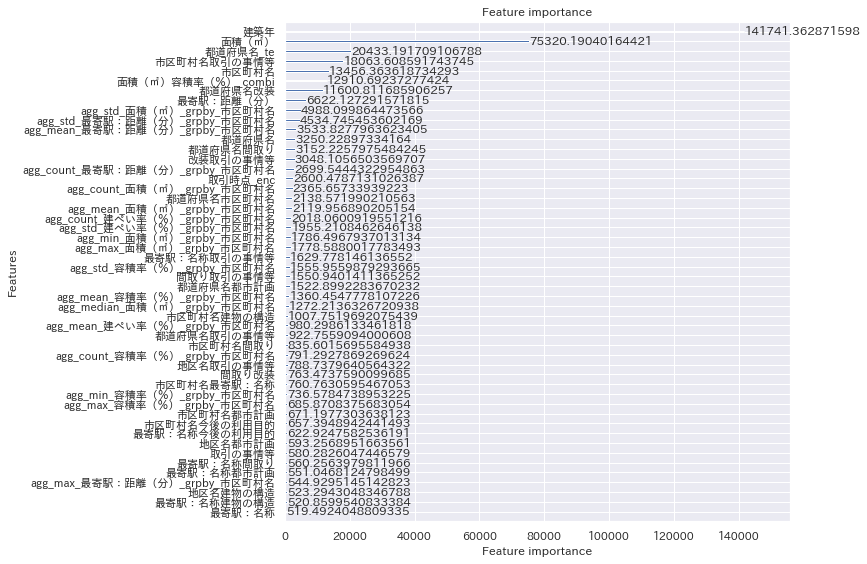

In [42]:
lgb.plot_importance(optimised_model, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.savefig(dir_for_output + '/feature_importance.png')
plt.show()
plt.close()

In [43]:
# LightGBM推論
y_pred = optimised_model.predict(test_x)

In [44]:
test_df[TARGET] = y_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
sub_df = pd.merge(sub_df[['ID']], test_df[['ID', TARGET]], on='ID')
sub_df.to_csv(dir_for_output + '/test_submission.csv', index=False)

In [46]:
# モデルを保存する
import pickle

file = 'trained_model.pkl'
pickle.dump(optimised_model, open(dir_for_output + "/" + file, 'wb'))